## Imports


In [1]:
import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
#from geopy.distance import geodesic
from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline
from sklearn.preprocessing import StandardScaler

## Normalizando Dados (menos lat e lon)

In [2]:
fit_df = pd.read_csv("LocTreino_Equipe_8.csv")
bts_df = pd.read_csv("dados_BTSs.csv")

fit_df.dropna(inplace=True)
fit_df.reset_index(inplace=True,drop=True)

scaler = StandardScaler()
numerical = ["pathBTS1","pathBTS2","pathBTS3","pathBTS4","pathBTS5","pathBTS6","taBTS1","taBTS2","taBTS3","taBTS4","taBTS5","taBTS6"]

fit_df[numerical] = pd.DataFrame(scaler.fit_transform(fit_df[numerical]))
display(fit_df.head())

,pontoId,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6,taBTS1,taBTS2,taBTS3,taBTS4,taBTS5,taBTS6
0,411,-8.075448,-34.893459,-0.245444,-0.119072,-0.317120,-0.050926,-0.658604,0.988673,0.492008,-1.223457,-0.551552,-1.223457,1.056149,1.386303
1,516,-8.074647,-34.890316,-0.320266,0.281964,1.004737,-0.799438,0.717571,1.750301,0.492008,-1.223457,0.511090,-1.223457,-0.125506,1.386303
2,1673,-8.069371,-34.898918,-0.380933,-0.427351,-0.686353,-0.166293,-0.105143,-1.308454,0.492008,-0.025605,-0.551552,-0.025605,1.056149,-0.055876
3,1140,-8.071290,-34.900772,0.045756,-0.029043,0.247808,0.284875,1.231143,0.285821,0.492008,-0.025605,-1.614194,-0.025605,1.056149,-0.055876
4,1043,-8.072050,-34.897167,-0.670110,-0.307313,-0.066041,-0.394280,0.565493,0.253984,0.492008,-1.223457,-0.551552,-1.223457,-0.125506,-0.055876


In [3]:
#Crossvalidation K-fold

kf = KFold(n_splits = 10, shuffle = False, random_state = None)
result = next(kf.split(fit_df), None)

train = fit_df.iloc[result[0]]
test =  fit_df.iloc[result[1]]

X_train = train.iloc[:, 1:3]
y_train = train[['pathBTS1',
                 'pathBTS2',
                 'pathBTS3',
                 'pathBTS4',
                 'pathBTS5',
                 'pathBTS6']]


X_test= test.iloc[:, 1:3]
y_test = test[['pathBTS1',
               'pathBTS2',
               'pathBTS3',
               'pathBTS4',
               'pathBTS5',
               'pathBTS6']]



In [4]:
from util.MultiRegressor import MultiRegressor 
from sklearn.metrics import mean_squared_error
from util.locdefs import get_distance_in_meters, geodesicDistance
from math import ceil

clf = neighbors.KNeighborsRegressor()
parameters = {'n_neighbors':list(range(1,30))}

#clf = RandomForestRegressor(random_state =100)
#parameters = {"max_depth":[2,4], "n_estimators": [50]}

#clf = SVR()
#parameters = {'kernel':["rbf"], "C":[0.1,1e3, 2e3],"gamma":[0.1,.5,1,5,10]}

#clf = AdaBoostRegressor(random_state =100)
#parameters = {"base_estimator": [DecisionTreeRegressor(max_depth=2)], "n_estimators": [50,100,200], "learning_rate":[0.5,1,2]}

multiregressor = MultiRegressor(clf, parameters)
multiregressor.fit(X_train, y_train)

print(multiregressor.best_parameters_)

y_pred = multiregressor.predict(X_test)

#display(y_pred)
ems = mean_squared_error(y_test, y_pred)
print("Error pathBTSs", ems)

#list_temp = []
#for i in range(y_test.shape[0]): 
 #   list_temp.append(get_distance_in_meters(y_pred[i][0], y_test["lat"][i], y_pred[i][1], y_test["lon"][i])/1000)
    #list_temp.append(geodesicDistance((y_pred[i][0], y_test["lat"][i]), (y_pred[i][1], y_test["lon"][i])))                

#ems_dist = mean_squared_error([0]*y_test.shape[0], list_temp)
#print("EMS with data in meters ", ems_dist)


[{'n_neighbors': 16}, {'n_neighbors': 3}, {'n_neighbors': 4}, {'n_neighbors': 28}, {'n_neighbors': 11}, {'n_neighbors': 4}]
Error pathBTSs 0.11752931887817379


# Generate Grid


In [5]:
max_lat = np.array(fit_df[["lat"]]).max()
min_lat = np.array(fit_df[["lat"]]).min()

max_lon = np.array(fit_df[["lon"]]).max()
min_lon = np.array(fit_df[["lon"]]).min()

left_up = (max_lat, min_lon)
right_up = (max_lat, max_lon)
left_down = (min_lat, min_lon)
right_down = (min_lat, max_lon)

#left_side = get_distance_in_meters(left_up[0], left_down[0], left_up[1], left_down[1])
#right_side = get_distance_in_meters(right_up[0], right_down[0], right_up[1], right_down[1])

left_side = geodesicDistance(left_up, left_down)
right_side = geodesicDistance(right_up, right_down)

#top_side = get_distance_in_meters(left_up[0], left_up[1], right_up[0], right_up[1])
#bottom_side = get_distance_in_meters(left_down[0], left_down[1], right_down[0], right_down[1])

top_side = geodesicDistance(left_up, right_up)
bottom_side = geodesicDistance(left_down, right_down)


side_a = max(left_side, right_side) #in km
side_b = max(top_side, bottom_side) #in km

print("Region dimensions in Km ", side_a, side_b)

cell_size = 0.020 #grid in kilometers
side_square = max(side_a, side_b)

grid_step = ceil(side_square / cell_size) + 1
grid_lats = np.linspace(min_lat, max_lat, 60)
grid_lons = np.linspace(min_lon, max_lon, 60)

lat_centers = [(l1 + l2)/2 for l1, l2 in zip(grid_lats, grid_lats[1:])]
lon_centers = [(l1 + l2)/2 for l1, l2 in zip(grid_lons, grid_lons[1:])]

samples = []
for lat in lat_centers:
    for lon in lon_centers:
        samples.append((lat, lon))

samples_df = pd.DataFrame({'lat' : [x[0] for x in samples], 'lon': [x[1] for x in samples]})
predict_path_loss = multiregressor.predict(samples_df)

#display(predict_path_loss)

cells = zip(samples, predict_path_loss)




Region dimensions in Km  2.0273225460434894 2.3950594892869215


In [6]:
import folium

bts_positions = bts_df[["lat", "lon"]].values

# Calculate map center
center_lat = np.mean([lat for lat in bts_positions[:, 0]])
center_lon = np.mean([lon for lon in bts_positions[:, 1]])

map_ = folium.Map(location=[center_lat, center_lon],
                              zoom_start=14,)

for lat, lon in bts_positions:
    marker = folium.CircleMarker(location=(lat,lon),
                                     color='black',
                                     weight=5,
                                     radius=2,
                                     fill_color='white',
                                     fill=True)
    marker.add_to(map_)

#map_

In [7]:
# Voronoi
from scipy.spatial import Voronoi

points = []
p_loss = []

for x in cells:
    points.append(x[0])
    p_loss.append(x) 
    
    #print(x)
#print(points)
#print(p_loss)

vor = Voronoi(points)

# Create map
map_ = folium.Map(location=[center_lat, center_lon],
                  zoom_start=13)

# Add voronoi cells
for i1, i2 in vor.ridge_vertices:
    if i1 != -1 and i2 != -1:
        p1 = vor.vertices[i1]
        p2 = vor.vertices[i2]
        folium.PolyLine([p1, p2],
                        color='black',
                        weight=0.2,
                        opacity=1).add_to(map_)

# Add corners
corners = [[max_lat, max_lon],
           [max_lat, min_lon],
           [min_lat, max_lon],
           [min_lat, min_lon]]

for c in corners:
    marker = folium.Marker(location=c)
    marker.add_to(map_)

# Add grid points
for (lat, lon), _ in cells:
    marker = folium.CircleMarker(location=(lat,lon),
                                 color='blue',
                                 weight=2,
                                 radius=1,
                                 fill_color='blue',
                                 fill=True)
    marker.add_to(map_)
    
map_.save("grid.html")

In [8]:
from scipy.spatial import distance
from numpy.linalg import inv, det

test_positions = pd.read_csv("LocTreino_Equipe_8.csv")
test_positions.dropna(inplace=True)
test_positions.reset_index(inplace=True,drop=True)
#display(test_positions)
scaler = StandardScaler()
numerical = ["pathBTS1","pathBTS2","pathBTS3","pathBTS4","pathBTS5","pathBTS6","taBTS1","taBTS2","taBTS3","taBTS4","taBTS5","taBTS6"]

test_positions[numerical] = pd.DataFrame(scaler.fit_transform(test_positions[numerical]))

p_loss_true = test_positions.iloc[:,3:9]
lat_lon = test_positions.iloc[:,1:3]

display(lat_lon.values)

print(len(p_loss_true), len(p_loss))

closest_list = []
closest=[]
for p1 in p_loss_true.values:
    temp = 1e8
    for p2 in p_loss:
        #mean = np.mean([p1, p2[1]])
        #V = np.cov(p1, p2[1])
        
        #p1_c = list(map(lambda x: x - mean, p1))
        #p2_c = list(map(lambda x: x - mean, p2[1]))
        
        #if(det(V) != 0):
        #d = distance.euclidean(p1, p2[1])
         #   VI = inv(V)
          #  d = distance.mahalanobis(p1_c, p2_c, VI)
        #else: 
        d = distance.euclidean(p1, p2[1])
        if(d < temp):
            temp = d
            closest = p2
    closest_list.append(closest)

lat_lon_closest = [list(x[0]) for x in closest_list]

ems = mean_squared_error(lat_lon.values, lat_lon_closest)
print(ems)

dif_dist = []
for i, j in zip(lat_lon_closest, lat_lon.values):
    dif_dist.append(geodesicDistance(i, j) * 1000)


print(sum(dif_dist)/len(dif_dist))



array([[ -8.075448, -34.893459],
       [ -8.074647, -34.890316],
       [ -8.069371, -34.898918],
       ...,
       [ -8.060418, -34.905537],
       [ -8.067195, -34.892452],
       [ -8.066568, -34.896744]])

1497 3481
2.6154779642148837e-06
150.15953410365591


Min Error (in meters):1.2947378353330945
Max Error (in meters):2106.4210478039095
Mean Error (in meters):150.15953410365614
Std. Deviation (in meters):203.01109615810427


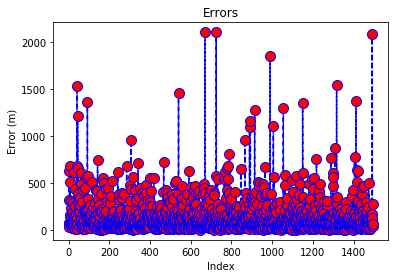

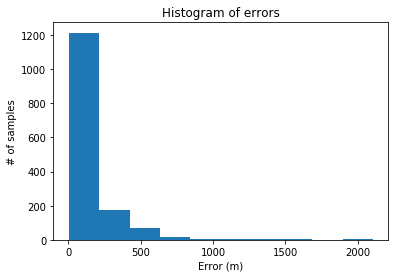

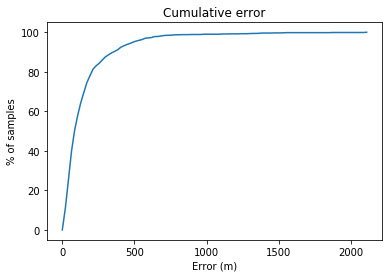

In [9]:
from util.statistics import get_errors,show_stats,show_stats_graphs,show_box_plots

error_fingerprint = get_errors(lat_lon, lat_lon_closest)
show_stats(error_fingerprint)
show_stats_graphs(error_fingerprint)

In [10]:
a = [[5.1,8.3], [3.8,18.489], [1.26, 10.95]]
m = np.mean(a)

print(m)
b = list(map(lambda x: x - m, a))

print(b)

mat = np.cov(b) 

mat_i = det(mat)

print(mat)
print(mat_i)


7.9831666666666665
[array([-2.88316667,  0.31683333]), array([-4.18316667, 10.50583333]), array([-6.72316667,  2.96683333])]
[[  5.12       23.5024     15.504    ]
 [ 23.5024    107.8833605  71.168205 ]
 [ 15.504      71.168205   46.94805  ]]
0.0


In [11]:
lat_lon_pred = pd.DataFrame({'lat': [x[0] for x in lat_lon_closest] ,'lon': [x[1] for x in lat_lon_closest]})


In [12]:
mapaPE = folium.Map(location=[-8.0593085,-34.9103383], zoom_start=15) #pernambuco
#data = pd.DataFrame({'lat':[max_lat, min_lat],'lon':[max_lon,min_lon ],})

for _, ponto in lat_lon_pred.iterrows():    
    folium.CircleMarker(
                        location=[ponto['lat'], ponto['lon']],
                         color='black',
                        weight=5,
                        radius=2,
             fill_color='white',
             fill=True
    ).add_to(mapaPE)


for _, ponto in bts_df.iterrows():    
    folium.CircleMarker(
                        location=[ponto['lat'], ponto['lon']],
                         color='red',
                        weight=5,
                        radius=2,
             fill_color='white',
             fill=True
    ).add_to(mapaPE)

for _, ponto in test_positions.iterrows():    
    folium.CircleMarker(
                        location=[ponto['lat'], ponto['lon']],
                         color='green',
                        weight=5,
                        radius=2,
             fill_color='white',
             fill=True
    ).add_to(mapaPE)    

mapaPE.save('predicoes-bts-treino-v.html')

In [23]:
output_pred = pd.DataFrame({'pontoId': test_positions['pontoId'].values,
                             'lat': test_positions['lat'].values,
                             'lon': test_positions['lon'].values, 
                             'lat_pred': [x[0] for x in lat_lon_closest], 
                             'lon_pred' : [x[1] for x in lat_lon_closest], 
                             'erro_loc' : dif_dist})
#display(output_pred.head())                                                                                                                              
output_pred.to_csv("output.csv")                                                                                                                         
                                                                                                                                             